In [ ]:
#install necessary modules
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
#!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam


drive.mount('/content/drive')

#Get directory paths
base_dir = "/content/drive/MyDrive/ML_project_fall_25/dataset/"

#Update paths for your generators
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "validate")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

#read images from directory and process them in batches of BATCH_SIZE, resize to (128,128)
BATCH_SIZE = 64
target_size = (128,128)

#generate dataset objects from each directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=True
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=False
)

#print number of classes and class names
num_classes = train_ds.element_spec[1].shape[-1]
class_names = train_ds.class_names
for i,name in enumerate(train_ds.class_names):
    print(f"{i}: {name}")
print("Number of Classes:", num_classes)

#normalization (values from [0,1] instead of [0,255])
def normalize(x, y):
    return tf.cast(x, tf.float32) / 255.0, y

#Prefetch for speed (creating dedicated buffer for next batch)
#num_parallel_calls: dynamic setting that allows the TensorFlow runtime to determine the optimal number of elements to buffer based on the hardware (T4 GPU in our case)
train_ds = train_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

#cache and prefetch
#cache saves the result of previous transformations in memory to avoid redundant work in subsequent epochs
train_ds = train_ds.cache().shuffle(2000).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.map(normalize).prefetch(tf.data.AUTOTUNE)

Found 51387 files belonging to 15 classes.
Found 11008 files belonging to 15 classes.
Found 11012 files belonging to 15 classes.
0: apple fm train
1: apple fresh train
2: apple rotten train
3: banana fm train
4: banana fresh train
5: banana rotten train
6: grape fm train
7: grape fresh train
8: grape rotten train
9: mango fm train
10: mango fresh train
11: mango rotten train
12: orange fm train
13: orange fresh train
14: orange rotten train
Number of Classes: 15


Found 51387 files belonging to 15 classes.


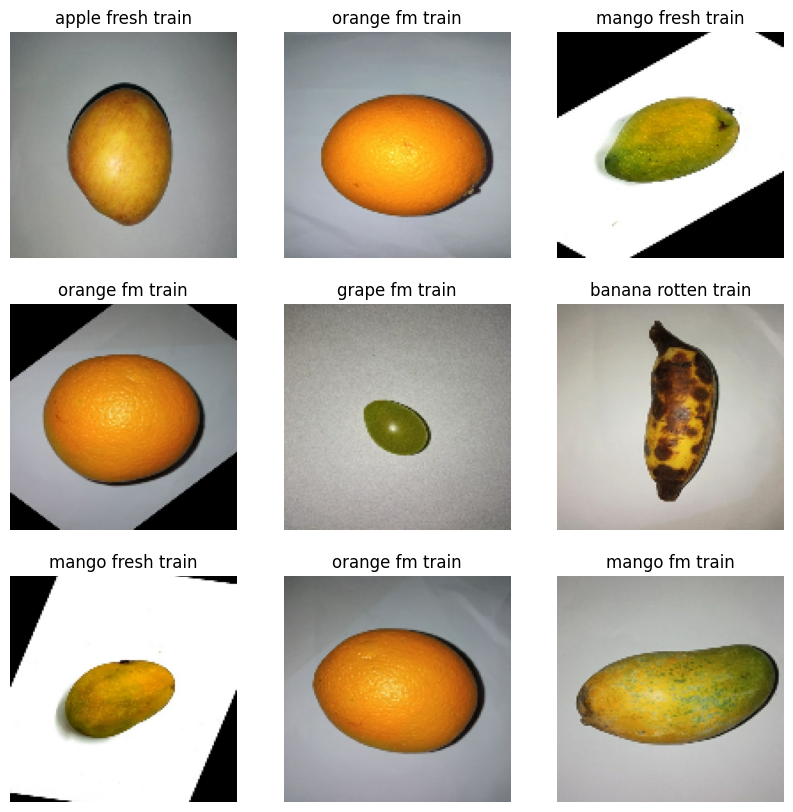

In [ ]:
#Create a temporary dataset for fast previewing without caching or shuffling
preview_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=target_size,
    shuffle=True
)

#gets one batch of train_dir (preview_ds)
preview_ds = preview_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
preview_ds = preview_ds.prefetch(1)
x_batch_fast, y_batch_fast = next(iter(preview_ds))

# Display the images and labels associated with them
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch_fast[i])
    class_index = np.argmax(y_batch_fast[i])
    plt.title(class_names[class_index])
    plt.axis('off')
plt.show()

In [ ]:
#ResNet Baseline (no pretrained weights)
from tensorflow.keras import layers, models, regularizers

#residual blocks utilizing skip connections
base_model = ResNet50(
    weights=None,
    include_top=False,
    input_shape=(128, 128, 3)
)


model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(), #condense feature map into a single vector
    tf.keras.layers.Dropout(0.4), #randomly sets 40% of neurons' output to 0, preventing overfitting
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.01)), #connects all features, reducing dimension with ReLU and L2 regularization
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation="softmax", dtype="float32") #converts the raw scores from the neurons into a probability distribution (list of 15 numbers)
])

#compile and train model
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 15)             │           975 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,719,823 (90.48 MB)

 Trainable params: 23,666,703 (90.28 MB)

 Non-trainable params: 53,120 (207.50 KB)

Epoch 1/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 290s 138ms/step - accuracy: 0.3215 - loss: 3.2756 - val_accuracy: 0.4777 - val_loss: 3.5359
Epoch 2/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 60s 75ms/step - accuracy: 0.7961 - loss: 1.4003 - val_accuracy: 0.5382 - val_loss: 3.2625
Epoch 3/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 61s 76ms/step - accuracy: 0.8800 - loss: 0.8888 - val_accuracy: 0.7138 - val_loss: 1.3884
Epoch 4/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 61s 76ms/step - accuracy: 0.9148 - loss: 0.6026 - val_accuracy: 0.7056 - val_loss: 1.8718
Epoch 5/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 61s 76ms/step - accuracy: 0.9323 - loss: 0.4302 - val_accuracy: 0.6559 - val_loss: 2.2500
Epoch 6/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 61s 77ms/step - accuracy: 0.9477 - loss: 0.3037 - val_accuracy: 0.7466 - val_loss: 1.9128
Epoch 7/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.9597 - loss: 0.2229 - val_accuracy: 0.7239 - val_loss: 1.5229
Epoch 8/10
803/803 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.9631 - loss: 0.1814 

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
test_loss, test_acc = model.evaluate(test_ds)

print("Validation Accuracy:", val_acc)
print("Test Accuracy:", test_acc)

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.7527 - loss: 1.2879
173/173 ━━━━━━━━━━━━━━━━━━━━ 20s 116ms/step - accuracy: 0.7699 - loss: 1.0728
Validation Accuracy: 0.7941496968269348
Test Accuracy: 0.8442608118057251


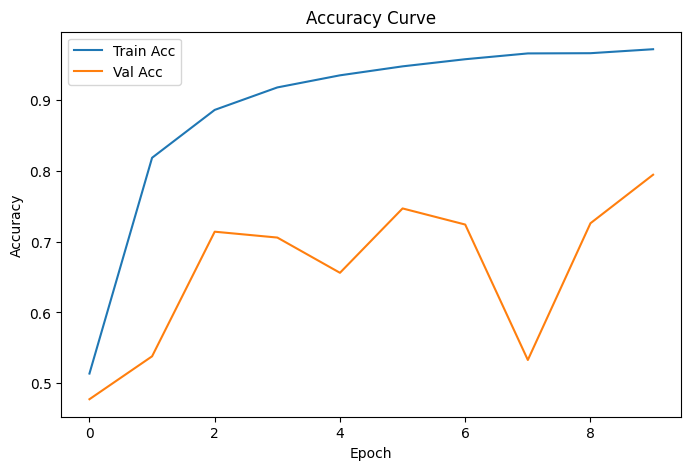

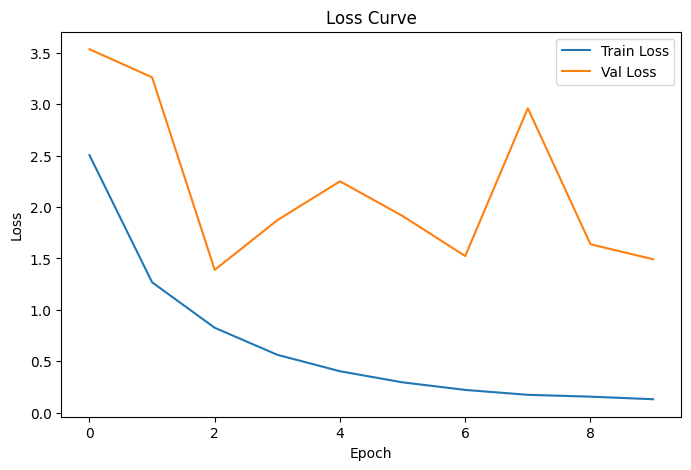

In [ ]:
# Accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Loss
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report

# Collect predictions
y_true = []
y_pred = []

for x, y in test_ds:
    preds = model.predict(x)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(y.numpy(), axis=1))

print(classification_report(y_true, y_pred))

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━

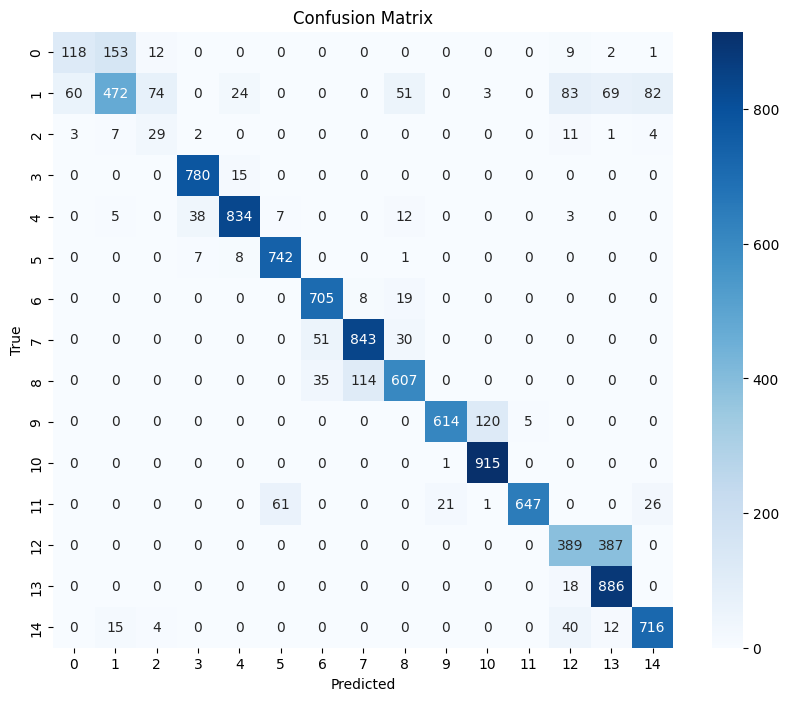

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#confusion_matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

['apple fm train', 'apple fresh train', 'apple rotten train', 'banana fm train', 'banana fresh train', 'banana rotten train', 'grape fm train', 'grape fresh train', 'grape rotten train', 'mango fm train', 'mango fresh train', 'mango rotten train', 'orange fm train', 'orange fresh train', 'orange rotten train']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


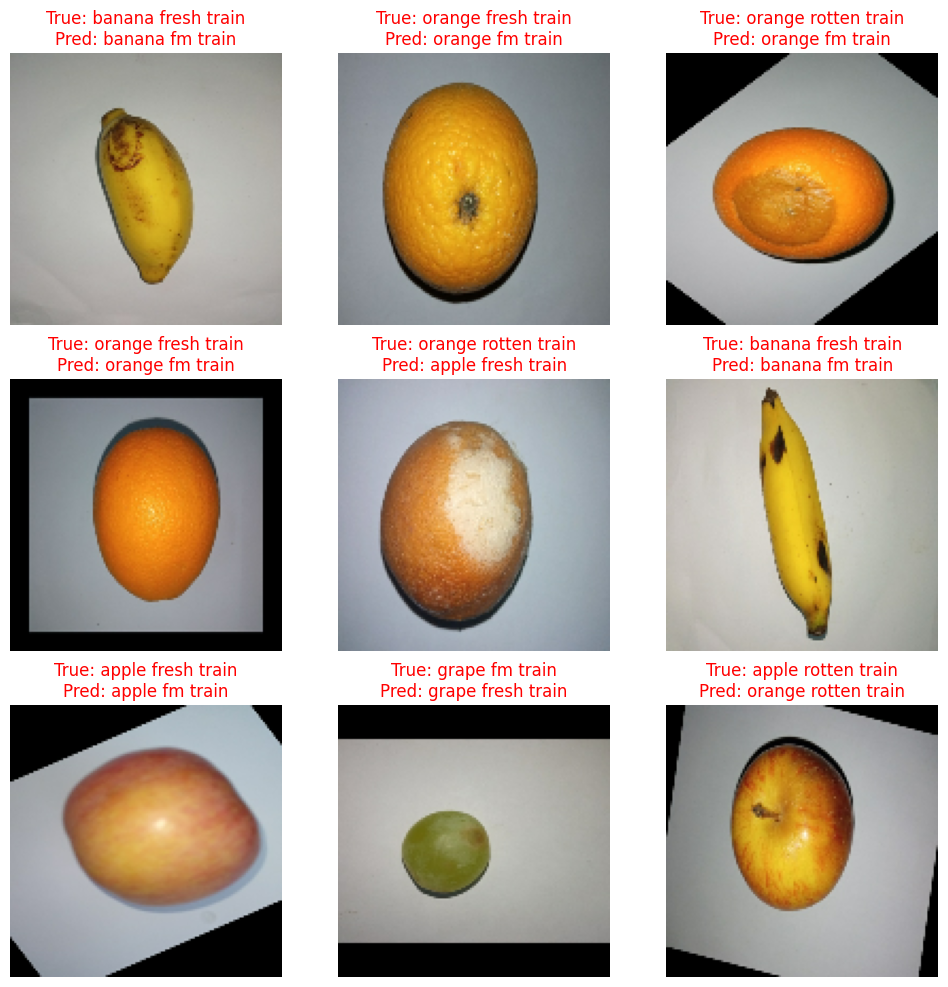

In [ ]:
print(class_names)

# Code to display mislabeled images
num_mislabeled_to_show = 9
mislabeled_count = 0
plt.figure(figsize=(12, 12))

#iterate through batches of train_ds until you get 9 images
for x_batch, y_batch in train_ds:
    preds = model.predict(x_batch)
    for i in range(len(x_batch)):
        true_label = class_names[np.argmax(y_batch[i])]
        pred_label = class_names[np.argmax(preds[i])]

        #mislabeled image
        if true_label != pred_label:
            mislabeled_count += 1
            plt.subplot(3, 3, mislabeled_count)
            plt.imshow(x_batch[i])
            plt.title(f"True: {true_label}\nPred: {pred_label}", color='red')
            plt.axis("off")

            if mislabeled_count >= num_mislabeled_to_show:
                break
    if mislabeled_count >= num_mislabeled_to_show:
        break

if mislabeled_count == 0:
    print("No mislabeled images found in this batch. All predictions were correct.")
else:
    plt.show()

In [ ]:
model_save_path = os.path.join(base_dir, "saved_model", "resnet50_baseline_model.keras")

os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
model.save(model_save_path)

print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/ML_project_fall_25/dataset/saved_model/resnet50_baseline_model.keras


In [ ]:
# This code would be run in a new session to load your model
# from tensorflow.keras.models import load_model

# model_load_path = os.path.join(base_dir, "saved_model", "resnet50_fruit_model.keras")
# loaded_model = load_model(model_load_path)

# print("Model loaded successfully!")
# loaded_model.summary()